In [1]:
from sahi.slicing import slice_coco
from sahi.utils.file import load_json

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

## Inspect the non sliced images

In [ ]:
/rds/general/user/jrb21/home/yolov5/runs/train

In [2]:
with open("/rds/general/user/jrb21/home/small-object-detection-benchmark/data/xview/coco/train_cars_trucks.json") as train_file:
    data_train_no_slice = json.load(train_file)

In [3]:
data_train_no_slice['images'][0]

{'height': 2931, 'width': 3093, 'id': 1, 'file_name': '5.tif'}

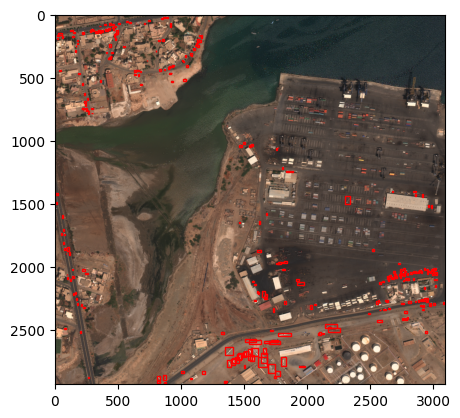

In [4]:
bboxes = []
for ann in data_train_no_slice['annotations']:
    if ann['image_id'] == 1:
        bbox = ann['bbox']
        bboxes.append(bbox)
        
im = Image.open('/rds/general/user/jrb21/home/train/train_images/5.tif')

# Create figure and axes
fig, ax = plt.subplots()
# Display the image
ax.imshow(im)

for x,y,w,h in bboxes:
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()

## Slicing

### Slice the train set

In [ ]:
coco_dict, coco_path = slice_coco(
    coco_annotation_file_path="/rds/general/user/jrb21/home/small-object-detection-benchmark/data/xview/coco/train_cars_trucks.json",
    image_dir="/rds/general/user/jrb21/home/train/train_images/",
    output_coco_annotation_file_name="slice_train_images",
    ignore_negative_samples=True,
    output_dir="/rds/general/user/jrb21/home/train/slice_train_images/",
    slice_height=400,
    slice_width=400,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    min_area_ratio=0.1,
    verbose=False,
    out_ext = '.png'
)

### Slice the validation set

In [ ]:
coco_dict, coco_path = slice_coco(
    coco_annotation_file_path="/rds/general/user/jrb21/home/small-object-detection-benchmark/data/xview/coco/val_cars_trucks.json",
    image_dir="/rds/general/user/jrb21/home/train/train_images/",
    output_coco_annotation_file_name="slice_valid_images",
    ignore_negative_samples=True,
    output_dir="/rds/general/user/jrb21/home/train/slice_valid_images/",
    slice_height=400,
    slice_width=400,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    min_area_ratio=0.1,
    verbose=False,
    out_ext = '.png'
)

### Convert the coco split dataset into YOLO

cd train/yolo_format/standard

cd train/yolo_format/include_negative

sahi coco yolov5 --image_dir /rds/general/user/jrb21/home/train/slice_train_images_with_negative --dataset_json_path /rds/general/user/jrb21/home/train/slice_json/trimmed_train_include_negative.json  --train_split 1

## Check the bounding boxes

### Train set

In [6]:
with open("/rds/general/user/jrb21/home/train/slice_train_images/slice_train_images_coco.json") as train_file:
    data_train = json.load(train_file)

In [18]:
def plot_image(n, train, data):
    
    x=data['images'][n]
    
    if train == True:
        path_str = '/rds/general/user/jrb21/home/train/slice_train_images/' + x['file_name']
    else:
        path_str = '/rds/general/user/jrb21/home/train/slice_valid_images/' + x['file_name']
        
    bboxes = []
    for ann in data['annotations']:
        if ann['image_id'] == x['id']:
            bbox = ann['bbox']
            bboxes.append(bbox)

    im = Image.open(path_str)

    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(im)

    for x,y,w,h in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

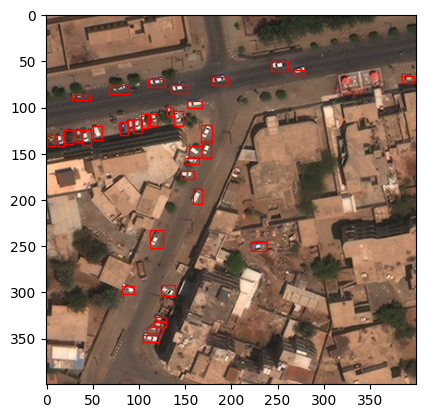

In [10]:
plot_image(n=1, train=True, data=data_train)

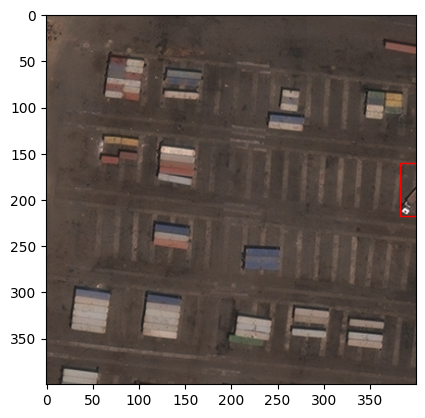

In [12]:
plot_image(n=15, train=True, data=data_train)

### Validation set

In [14]:
with open("/rds/general/user/jrb21/home/train/slice_valid_images/slice_valid_images_coco.json") as valid_file:
    data_valid = json.load(valid_file)

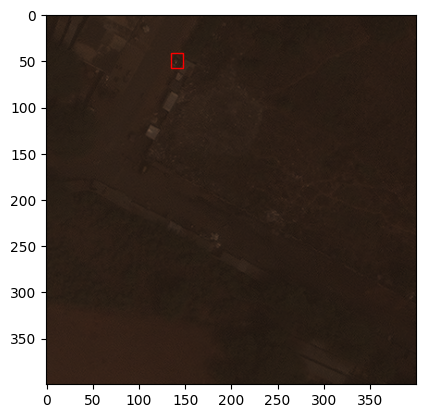

In [16]:
plot_image(n=5387, train=False, data=data_valid)

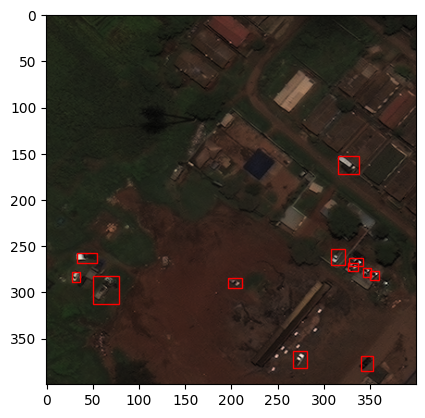

In [19]:
plot_image(n=18, train=False, data=data_valid)

## Explore the data

In [ ]:
with open("/rds/general/user/jrb21/home/train/slice_train_images/slice_train_images_coco.json") as train_file:
    data_train = json.load(train_file)
    
with open("/rds/general/user/jrb21/home/train/slice_valid_images/slice_valid_images_coco.json") as valid_file:
    data_valid = json.load(valid_file)

In [3]:
with open("slice_train_images_coco.json") as train_file:
    data_train = json.load(train_file)
    
with open("slice_valid_images_coco.json") as valid_file:
    data_valid = json.load(valid_file)

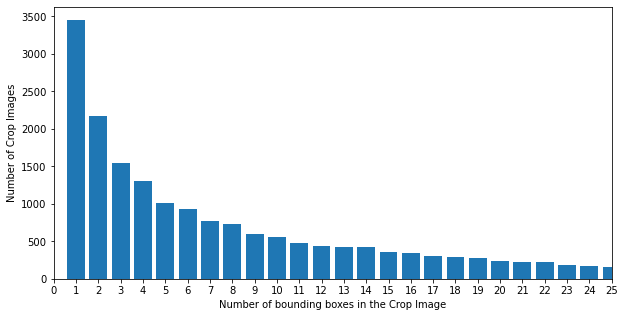

In [15]:
from collections import defaultdict
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

counts = defaultdict(int)
for ann in data_train['annotations']:
    image_id = ann['image_id']
    counts[image_id]+=1
    
    
listofcounts = np.bincount(list(counts.values()))

fig, ax = plt.subplots(figsize = (10,5))
plt.bar(np.arange(0, len(listofcounts)), listofcounts)
plt.xlim(0, 25)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('Number of bounding boxes in the Crop Image')
plt.ylabel('Number of Crop Images')
plt.savefig('bboxes per crop', dpi = 300)
plt.show()

## Trim off some of the negative samples

### Train

In [23]:
from collections import defaultdict
import copy

def trim(data, n):
    annotation_count = defaultdict(int)
    for ann in data['annotations']:
        image_id = ann['image_id']
        annotation_count[image_id]+=1
    
    # Find images with at least n annotations    
    images = []
    for img in data['images']:
        image_id = img['id']
        if annotation_count[image_id] >= n:
            images.append(img)
            
    # find annotations with at least n annotations
    annotations = []
    for ann in data['annotations']:
        image_id = ann['image_id']
        if annotation_count[image_id] >= n:
            annotations.append(ann)
            
    new_data = copy.copy(data)
    new_data['images'] = images
    new_data['annotations'] = annotations
    
    return new_data

In [8]:
import math

In [42]:
import random
import copy
def redistribute(data):
    annotation_count = defaultdict(int)
    for ann in data['annotations']:
        image_id = ann['image_id']
        annotation_count[image_id]+=1
    
    
    more_than_four = {k: v for k, v in annotation_count.items() if v >= 4}
    three = {k: v for k, v in annotation_count.items() if v == 3}
    two = {k: v for k, v in annotation_count.items() if v == 2}
    one = {k: v for k, v in annotation_count.items() if v == 1}
    zero = {k: v for k, v in annotation_count.items() if v == 0}
    
    length_more_than_four = len(more_than_four.values())
    length_all = int(length_more_than_four/0.9)
    length_zero = int(0.07 * length_all)
    length_one = int(0.01 * length_all)
    length_two = int(0.01 * length_all)
    length_three = int(0.01 * length_all)
    
    
    more_than_four_ids = list(more_than_four.keys())
    three_ids = random.sample(list(three.keys()), length_three)
    two_ids = random.sample(list(two.keys()), length_two)
    one_ids = random.sample(list(one.keys()), length_one)
    
    ids = more_than_four_ids + three_ids + two_ids + one_ids
    
    # Find images with at least n annotations    
    images = []
    for img in data['images']:
        image_id = img['id']
        if image_id in ids:
            images.append(img)
            
    # find annotations with at least n annotations
    annotations = []
    for ann in data['annotations']:
        image_id = ann['image_id']
        if image_id in ids:
            annotations.append(ann)
            
    new_data = copy.copy(data)
    new_data['images'] = images
    new_data['annotations'] = annotations
    
    return new_data

In [24]:
new_data_train = trim(data_train, 4)

In [25]:
new_data_valid = trim(data_valid, 4)

### Resitribute

In [43]:
new_data_train = redistribute(data_train)

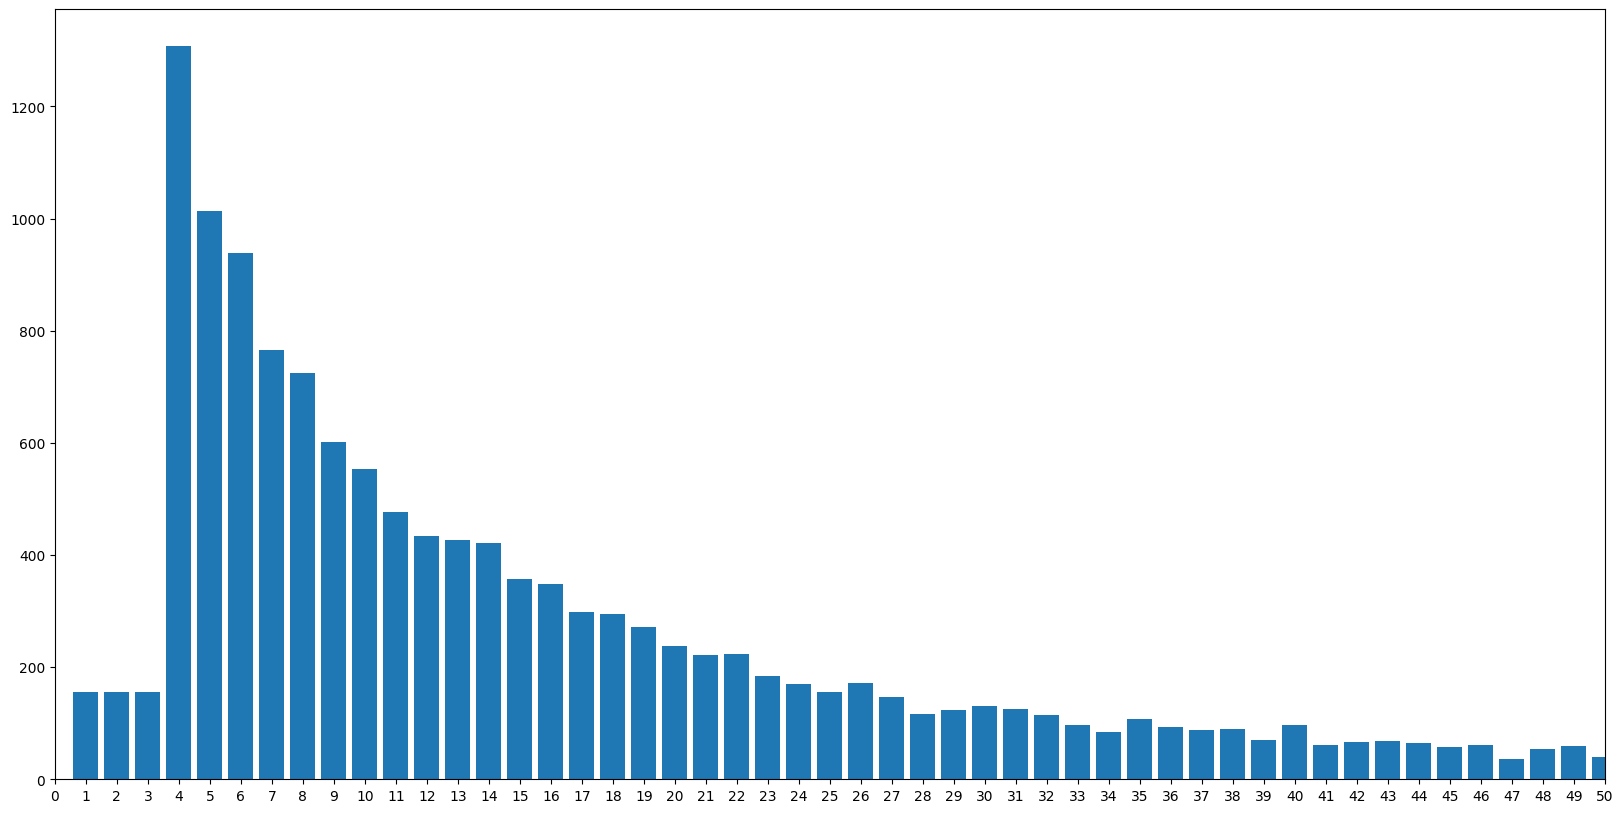

In [44]:
from collections import defaultdict
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

counts = defaultdict(int)
for ann in new_data_train['annotations']:
    image_id = ann['image_id']
    counts[image_id]+=1
    
    
listofcounts = np.bincount(list(counts.values()))

fig, ax = plt.subplots(figsize = (20,10))
plt.bar(np.arange(0, len(listofcounts)), listofcounts)
plt.xlim(0, 50)
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.show()

### Check the trimmed annotations are correct

In [ ]:
plot_image(n=57, train=True, data=new_data_train)

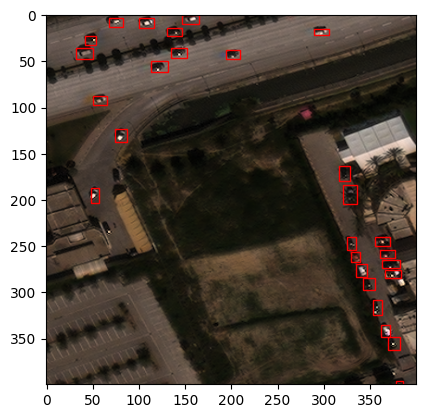

In [27]:
plot_image(n=97, train=False, data=new_data_valid)

### Export the jsons

In [28]:
import json
with open('/rds/general/user/jrb21/home/train/slice_json/trimmed_train.json', 'w') as f:
    json.dump(new_data_train, f)
    
with open('/rds/general/user/jrb21/home/train/slice_json/trimmed_valid.json', 'w') as f:
    json.dump(new_data_valid, f)

### Make YOLO format